# K-Nearest Neighbor Classifier

### Objective:

The purpose of this script is to build a K-Nearest Neighbor (KNN) Classifier to do rudimentary image classification. This model does not include any gradient based optimization, and all the heavy lifting is done at testing time. This should serve as learning material for myself (and any readers) who are interesting in Machine Learning.

### Getting Setup:

Import necessary modules:

In [1]:
import os
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

Matplotlib does not play nice with Jupyter Notebook, so here is some setup code to get it run properly. 
'%' is a 'line magic' command that is an alias for a command call

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # default size of plot
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Reload external python modules:

In [3]:
%load_ext autoreload
%autoreload 2

Begin loading in the data:

In [4]:
# Get Data Directory
home = r'C:\Users\joshu\Documents\CS231n\assignment1'
cifar10_dir = home + r'\cs231n\datasets\cifar-10-batches-py'

In [5]:
# utils function
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# Report data size
print('Training Data size: {} \n'
      'Training Lbls size: {} \n'
      'Test Data size: {} \n'
      'Test Lbls size: {} \n'.format(X_train.shape,
                                                          y_train.shape,
                                                          X_test.shape,
                                                          y_test.shape))


Training Data size: (50000, 32, 32, 3) 
Training Lbls size: (50000,) 
Test Data size: (10000, 32, 32, 3) 
Test Lbls size: (10000,) 



### Begin building the KNN Pipeline

In [6]:
# Visualize some data examples from each class
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7

for y, cls in enumerate(classes):
    break
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        
        plt_idx = i * num_classes + y + 1
        
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i ==0:
            plt.title(cls)

print('Sample of Dataset:\n')
plt.show()
        

Sample of Dataset:



In [7]:
# Sub sample data set to quickly develop model
train_sample_size = 5000
mask = range(train_sample_size)

X_train = X_train[mask]
y_train = y_train[mask]


test_sample_size = 500
mask = range(test_sample_size)
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test  = np.reshape(X_test, (X_test.shape[0], -1))
print('Sample set reshaped: ', X_train.shape)

Sample set reshaped:  (5000, 3072)


#### Commentary on above:
I wanted to make sure the shapes of my arrays are kosher, so this is just to check my work. 

### Classify the Test data with KNN

Example code: shape of label set:  (5000,)


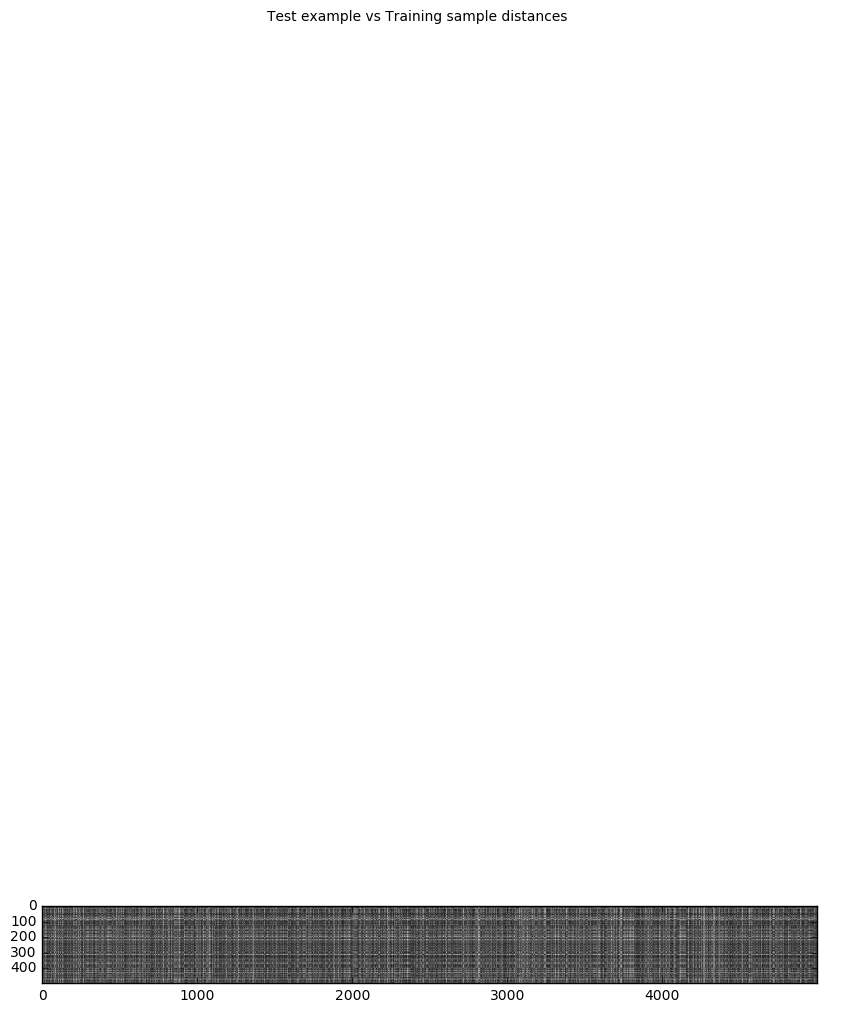

In [25]:
from cs231n.classifiers import KNearestNeighbor

# Instantiate a classifier object, Train it
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
print('Example code: shape of label set: ', y_train.shape)

# Visualization Exercise: Nearest Neighbor
dists = classifier.compute_distances_no_loops(X_test)

# Visualize the distances (training example distances per test example)
plt.suptitle('Test example vs Training sample distances')
plt.imshow(dists, interpolation='none')


#### Commentary on above:
This graph is showing the similarity of all the training examples to each test example. The lighter the example, the more similar the example. It seems like there are some train examples that are similar to all test examples (vertical white band)
and some test examples that are similar to most train examples. This is a bit quirky in my opinion, and makes me a little bit skeptical of my own methodologies.

In [21]:
# Generate predictions

print('Shape of validation set: ',X_test.shape)
pred_y_test = classifier.predict(X_test, k=1, num_loops=0)

num_correct = np.sum(pred_y_test == y_test)
accuracy = num_correct / test_sample_size

# Print results:
print('\n\nScore:'
      '{} / {} correct, accuracy: {}'
      .format(num_correct, test_sample_size, accuracy))


Shape of validation set:  (500, 3072)


Score:137 / 500 correct, accuracy: 0.274


### Cross Validation

Generate multiple sets of the training data to do some cross validation on the generated model.

In [11]:
num_folds = 5

x_train_folds = np.array(np.array_split(X_train, num_folds))
y_train_folds = np.array(np.array_split(y_train, num_folds))

print('Cross Validation sets generated. '
      'Matrix: ', x_train_folds.shape)



Cross Validation sets generated. Matrix:  (5, 1000, 3072)


Run the model against different quantities of nearest neighbors (k):

In [34]:
# Set choices and create a dictionary to hold results
k_choices = [1, 3, 5, 8, 10, 20, 50, 99]
k_accuracies = {}
folds = range(num_folds)

print("#kvals\t", 'f0ld1\tfold2\tfold3\tfold4\tfold5')
for k in k_choices:
    
    # initialize an empty list of fold tests
    validation_tests = []
    
    for val_fold in folds:
        
        # create a validation set of that fold
        valid_set = x_train_folds[val_fold]
        valid_lbl = y_train_folds[val_fold]
    
        # remove the validation fold
        train_set = np.delete(x_train_folds, val_fold, axis=0)
        train_lbl = np.delete(y_train_folds, val_fold, axis=0) 
        
        # reshape to a 2D array of examples(M) x features(N)
        train_set = np.reshape(train_set, (-1, train_set.shape[2]))
        train_lbl = np.reshape(train_lbl, (-1,))
        
        # train the model on the training set
        classifier = KNearestNeighbor()
        classifier.train(train_set, train_lbl)
        
        # test the model on the validation set
        predictions = classifier.predict(valid_set, k)

        # add the accuracy result to the fold test list
        correct = np.sum(predictions == valid_lbl)
        accuracy = correct / len(valid_lbl)
        validation_tests.append(accuracy)
        
        
    k_accuracies[k] = validation_tests
    print("{} KNN:\t".format(k), '\t'.join([str(i * 100)+'%' for i in validation_tests]))

#kvals	 f0ld1	fold2	fold3	fold4	fold5
1 KNN:	 9.9%	10.0%	9.7%	9.7%	9.7%
3 KNN:	 9.9%	10.0%	9.7%	9.7%	9.7%
5 KNN:	 9.9%	10.0%	9.7%	9.7%	9.7%
8 KNN:	 9.9%	10.0%	9.7%	9.7%	9.7%
10 KNN:	 9.9%	10.0%	9.7%	9.7%	9.7%
20 KNN:	 9.9%	10.0%	9.7%	9.7%	9.7%
50 KNN:	 9.9%	10.0%	9.7%	9.7%	9.7%
99 KNN:	 9.9%	10.0%	9.7%	9.7%	9.7%


#### Commentary on Above:
For a little while I was very confused on why the percentages didn't change with different k sets. The table printed above is a result of my debugging attempts. Looking into the KNN classifier program, the distances of all the training examples to any given test example [i] is sorted, and only the K values are kept. This is reasonable, but as it turns out, the output of a predict label only returns the closest K value, no matter how many K's were chosen (the closest K value being the first value in the sorted 'distances' list). 

As a result, it doesn't matter how many K nearest neighbors are considered, because the only one that seems to matter is the closest one. Perhaps this is an incorrect implementation, because these accuracies seem absurdly low.

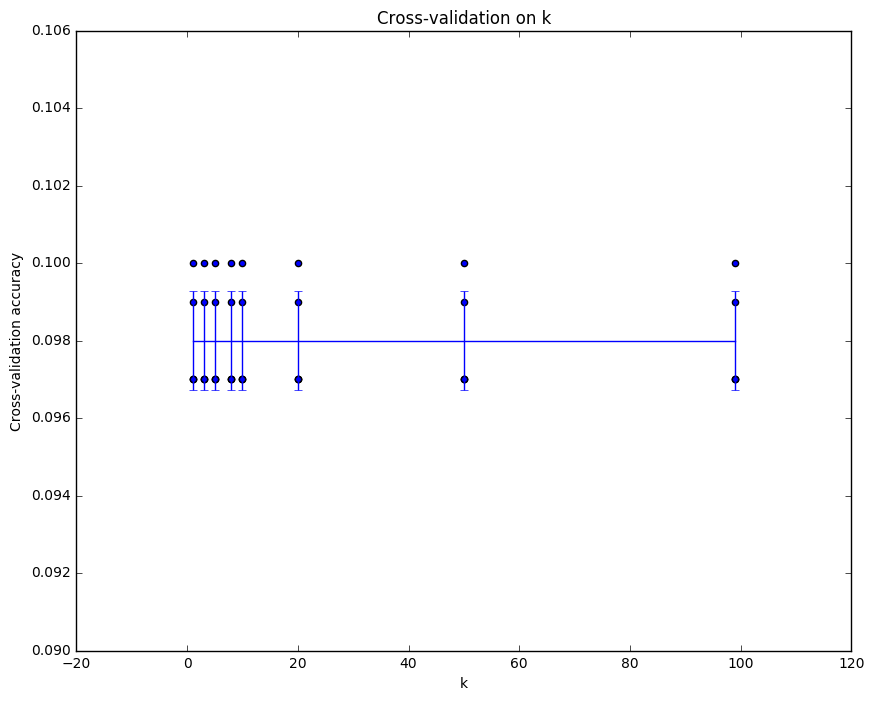

In [40]:
# plot the raw observations
for k in k_choices:
    accuracies = k_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [39]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data.
best_k = 1
num_test = len(y_test)
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got {} / {} correct => accuracy: {}'.format(num_correct, num_test, accuracy))

Got 40 / 500 correct => accuracy: 0.08
